In [1]:
import numpy as np
import ROOT
import keras
from matplotlib import pyplot as plt
from joblib import load
dnn = keras.models.load_model('models/phiDNN')
model = dnn
ada = load('models/AdaBoost')
grad = load('models/Gradient Boost')
forest = load('models/Random Forest')
with open('data/processed/X_train.npy', 'rb') as f:
    X_train = np.load(f)
with open('data/processed/y_train.npy', 'rb') as f:
    y_train = np.load(f)
with open('data/processed/X_test.npy', 'rb') as f:
    X_test = np.load(f)
with open('data/processed/y_test.npy', 'rb') as f:
    y_test = np.load(f)

tr = model.evaluate(X_train, y_train)
ts = model.evaluate(X_test, y_test)

print("Score\tTrain\tTest")
for l, a, b in zip(['loss', 'acc', 'AUC'], tr, ts):
    print(f"{l}:\t{a:.3f}\t{b:.3f}")

Welcome to JupyROOT 6.24/04


2021-09-16 21:42:19.736895: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-16 21:42:20.213913: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:03:00.0, compute capability: 8.6
2021-09-16 21:42:20.896735: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


 37/947 [>.............................] - ETA: 3s - loss: 0.2024 - accuracy: 0.9088 - auc: 0.9722

2021-09-16 21:42:22.101125: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


474/474 [==============================] - 0s 967us/step - loss: 0.2571 - accuracy: 0.9025 - auc: 0.9482
Score	Train	Test
loss:	0.237	0.257
acc:	0.910	0.903
AUC:	0.959	0.948


In [2]:
from ROOT.Math import PxPyPzMVector

y_pred = model.predict(X_test).T[0]
y_pred_ada = ada.predict_proba(X_test)[:,1]
y_pred_grad = grad.predict_proba(X_test)[:,1]
y_pred_forest = forest.predict_proba(X_test)[:,1]

#TODO: Add imkpkm and imprkm -- need to remove the scaling that I did in the preprocessing
pmass, emass, kpmass, kmmass = 0.938272, 0.000511, 0.493677, 0.493677
imkpkm, imprkm = np.zeros(len(y_test)), np.zeros(len(y_test))
for i, ev in enumerate(X_test):
    e = PxPyPzMVector(ev[1], ev[2], ev[3], emass)
    p = PxPyPzMVector(ev[5], ev[6], ev[7], pmass)
    kp = PxPyPzMVector(ev[9], ev[10], ev[11], kpmass)
    km = PxPyPzMVector(ev[13], ev[14], ev[15], kmmass)
    imkpkm[i] = (kp+km).mass()
    imprkm[i] = (p+km).mass()

X_test = np.c_[X_test, imkpkm.T, imprkm.T]

# bg_true, bg_pred, phi_true, phi_pred = X_test[y_test == 0], X_test[y_pred == 0], X_test[y_test == 1], X_test[y_pred == 1]
bg_true, bg_pred, phi_true, phi_pred = X_test[y_test == 0], X_test[y_pred <= 0.5], X_test[y_test == 1], X_test[y_pred > 0.5]

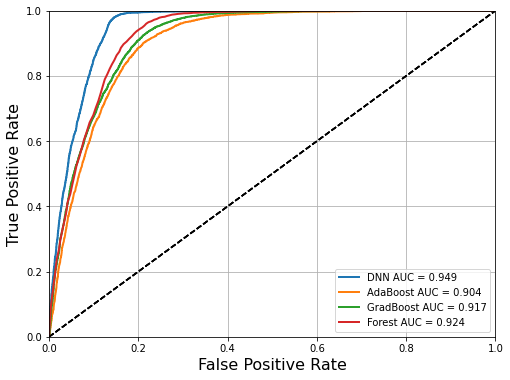

In [3]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(y_test, y_pred)
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred_ada)
fpr_grad, tpr_grad, thresholds_grad = roc_curve(y_test, y_pred_grad)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, y_pred_forest)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_dnn, tpr_dnn, f"DNN AUC = {roc_auc_score(y_test, y_pred):.3f}")
plot_roc_curve(fpr_ada, tpr_ada, f"AdaBoost AUC = {roc_auc_score(y_test, y_pred_ada):.3f}")
plot_roc_curve(fpr_grad, tpr_grad, f"GradBoost AUC = {roc_auc_score(y_test, y_pred_grad):.3f}")
plot_roc_curve(fpr_forest, tpr_forest, f"Forest AUC = {roc_auc_score(y_test, y_pred_forest):.3f}")
plt.legend();

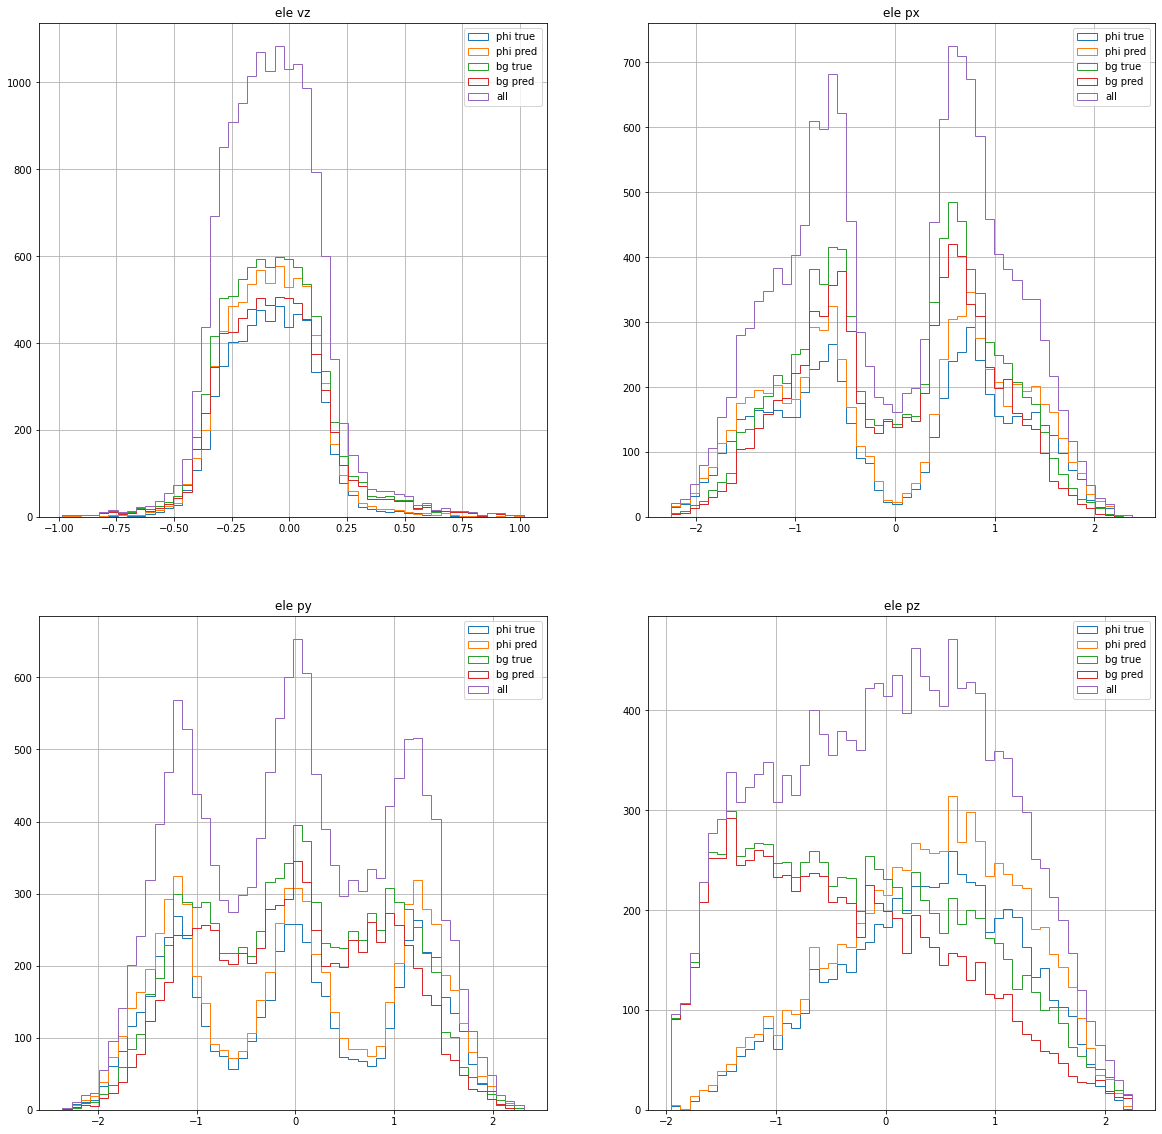

In [4]:
# Electron
bins=50
f, axs = plt.subplots(2, 2, figsize=(20,20))
for i, ax in enumerate(axs.flatten()):
    ax.set_title(["ele vz", "ele px", "ele py", "ele pz"][i])
    
    _, b, _  = ax.hist(phi_true[:, i], bins=bins, histtype="step", label="phi true")
    ax.hist(phi_pred[:, i], bins=b, histtype="step", label="phi pred")

    ax.hist(bg_true[:, i], bins=b, histtype="step", label="bg true")
    ax.hist(bg_pred[:, i], bins=b, histtype="step", label="bg pred")
    
    ax.hist(X_test[:, i], bins=b, histtype="step", label="all")

    ax.grid()
    ax.legend()
    # ax.set_yscale('log')


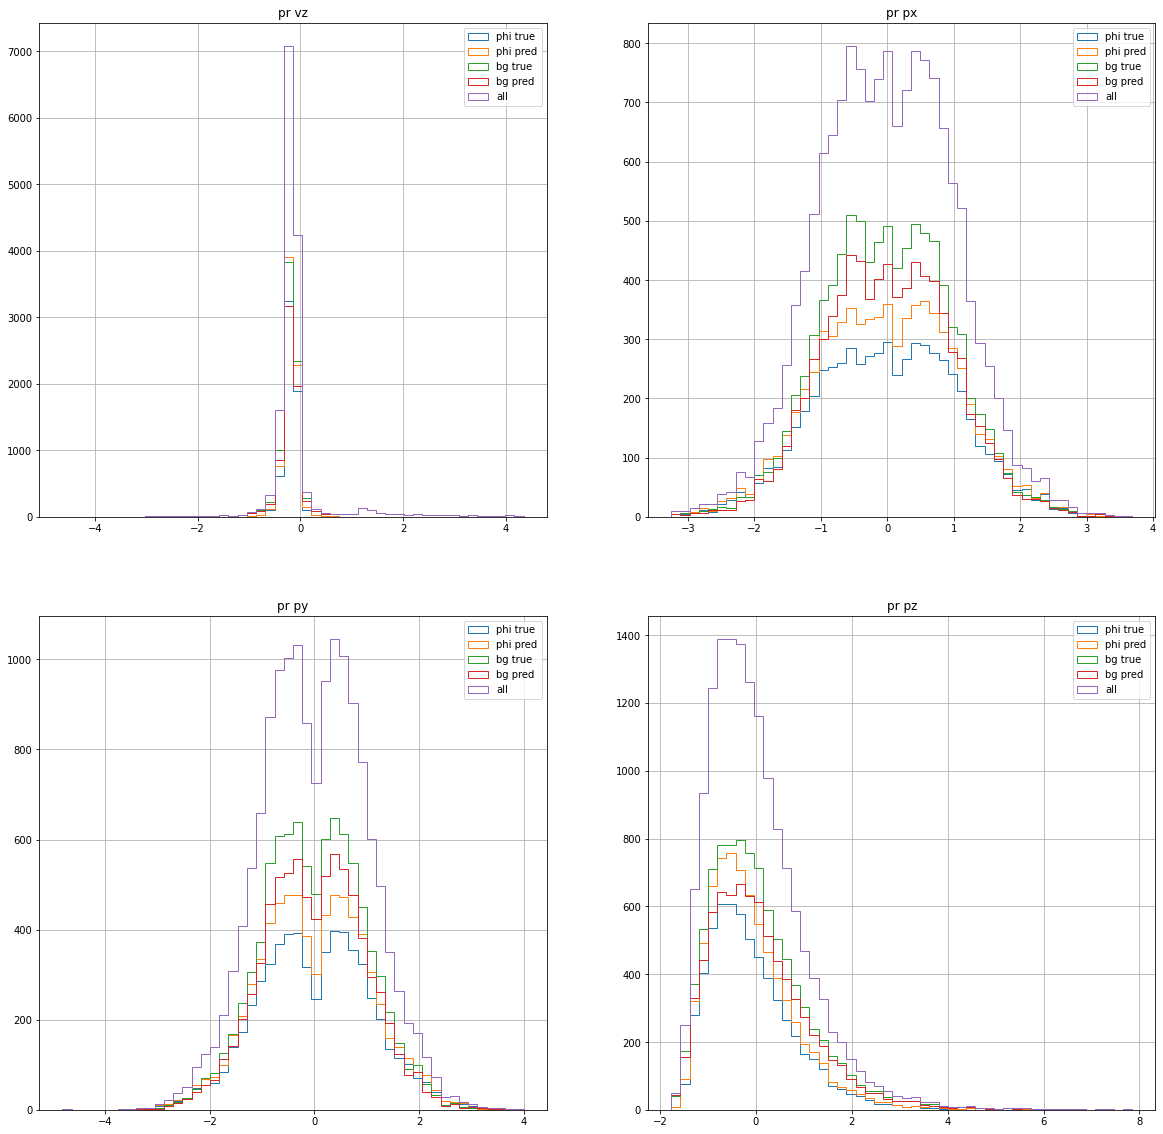

In [5]:
# Proton
f, axs = plt.subplots(2, 2, figsize=(20,20))
for i, ax in enumerate(axs.flatten()):
    ax.set_title(["pr vz", "pr px", "pr py", "pr pz"][i])
    
    i += 4
    _, b, _  = ax.hist(phi_true[:, i], bins=bins, histtype="step", label="phi true")    
    ax.hist(phi_pred[:, i], bins=b, histtype="step", label="phi pred")

    ax.hist(bg_true[:, i], bins=b, histtype="step", label="bg true")
    ax.hist(bg_pred[:, i], bins=b, histtype="step", label="bg pred")

    ax.hist(X_test[:, i], bins=b, histtype="step", label="all")
    
    ax.grid()
    ax.legend()
    # ax.set_yscale('log')

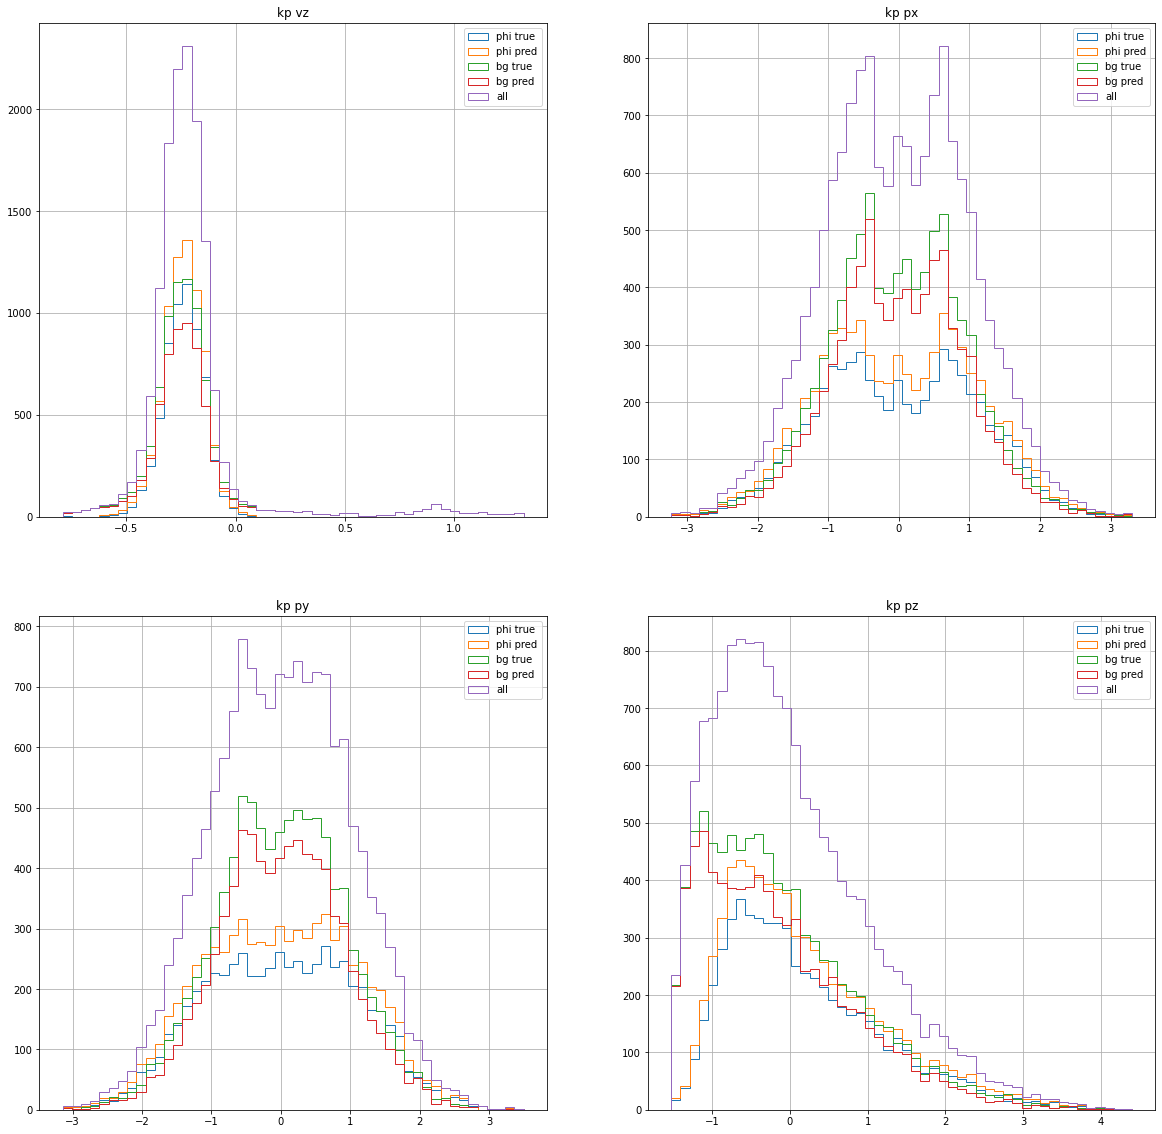

In [6]:
# Kaon Plus
f, axs = plt.subplots(2, 2, figsize=(20,20))
for i, ax in enumerate(axs.flatten()):
    ax.set_title(["kp vz", "kp px", "kp py", "kp pz"][i])

    i+=8
    
    _, b, _  = ax.hist(phi_true[:, i], bins=bins, histtype="step", label="phi true")
    ax.hist(phi_pred[:, i], bins=b, histtype="step", label="phi pred")

    ax.hist(bg_true[:, i], bins=b, histtype="step", label="bg true")
    ax.hist(bg_pred[:, i], bins=b, histtype="step", label="bg pred")
    
    ax.hist(X_test[:, i], bins=b, histtype="step", label="all")

    ax.grid()
    ax.legend()
    # ax.set_yscale('log')

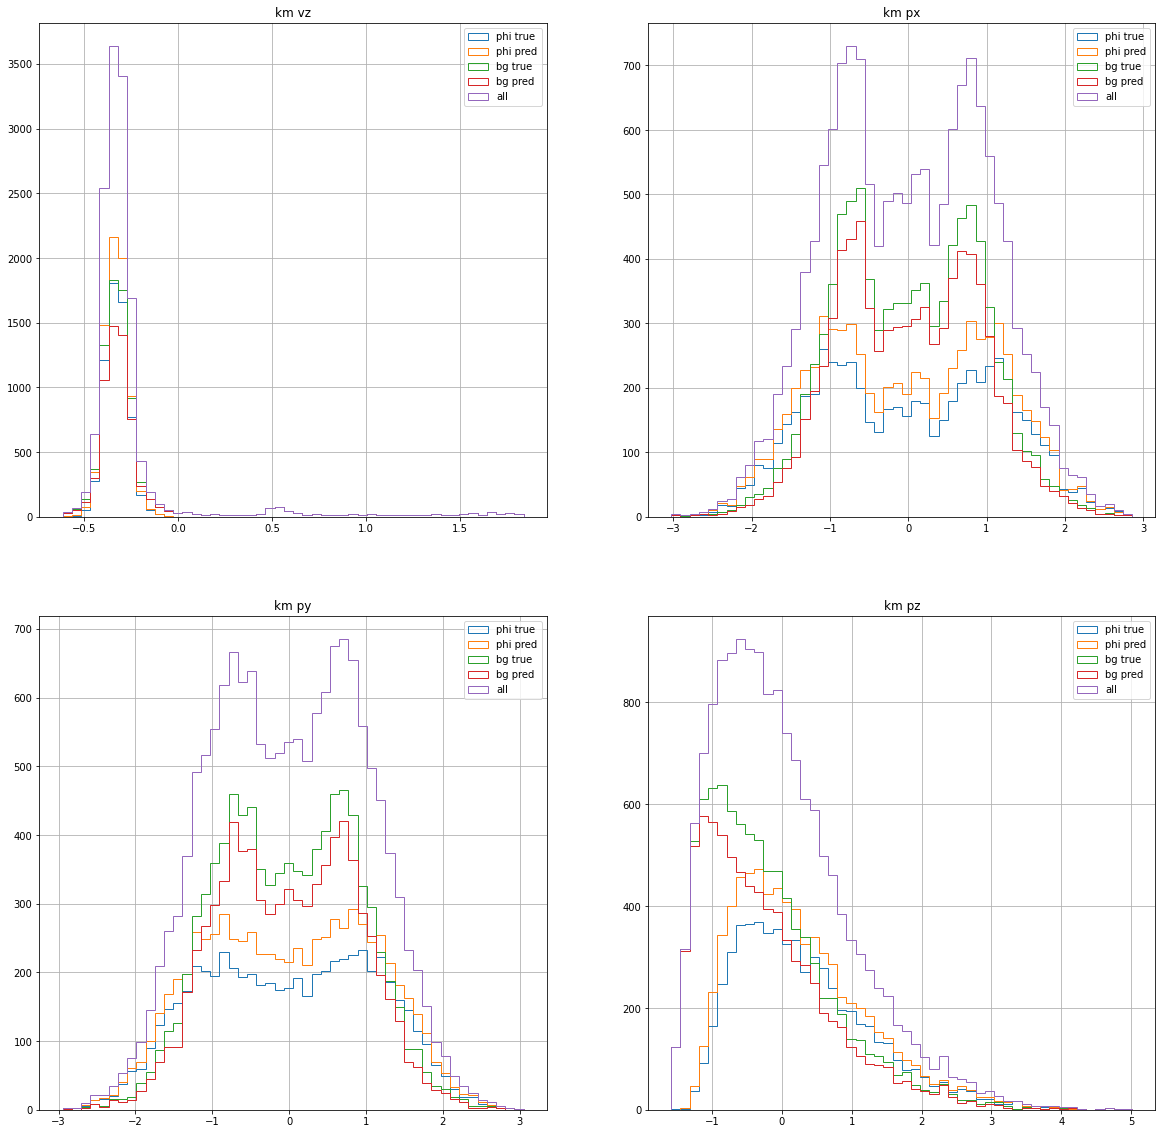

In [7]:
# Kaon Minus
f, axs = plt.subplots(2, 2, figsize=(20,20))
for i, ax in enumerate(axs.flatten()):
    ax.set_title(["km vz", "km px", "km py", "km pz"][i])

    i+=12
    _, b, _  = ax.hist(phi_true[:, i], bins=bins, histtype="step", label="phi true")
    ax.hist(phi_pred[:, i], bins=b, histtype="step", label="phi pred")

    ax.hist(bg_true[:, i], bins=b, histtype="step", label="bg true")
    ax.hist(bg_pred[:, i], bins=b, histtype="step", label="bg pred")
    ax.hist(X_test[:, i], bins=b, histtype="step", label="all")
    
    ax.grid()
    ax.legend()
    # ax.set_yscale('log')

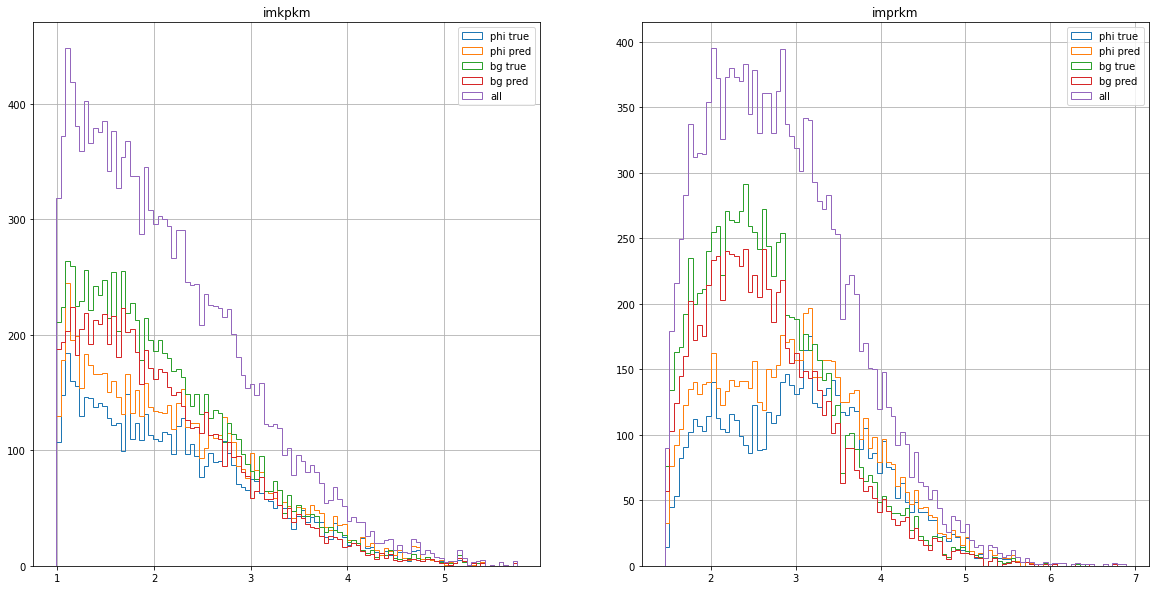

In [8]:
# Invariant Mass KpKm and PrKm
# !: Not real because of StandardScaler
# Should be seeing cuts in imprkm from lambda resonances but i'm not....
bins=100
f, axs = plt.subplots(1, 2, figsize=(20,10))
for i, ax in enumerate(axs.flatten()):
    ax.set_title(["imkpkm", "imprkm"][i])

    i+=16
    _, b, _  = ax.hist(phi_true[:, i], bins=bins, histtype="step", label="phi true")
    ax.hist(phi_pred[:, i], bins=b, histtype="step", label="phi pred")

    ax.hist(bg_true[:, i], bins=b, histtype="step", label="bg true")
    ax.hist(bg_pred[:, i], bins=b, histtype="step", label="bg pred")
    ax.hist(X_test[:, i], bins=b, histtype="step", label="all")
    
    ax.grid()
    ax.legend()
    # ax.set_yscale('log')

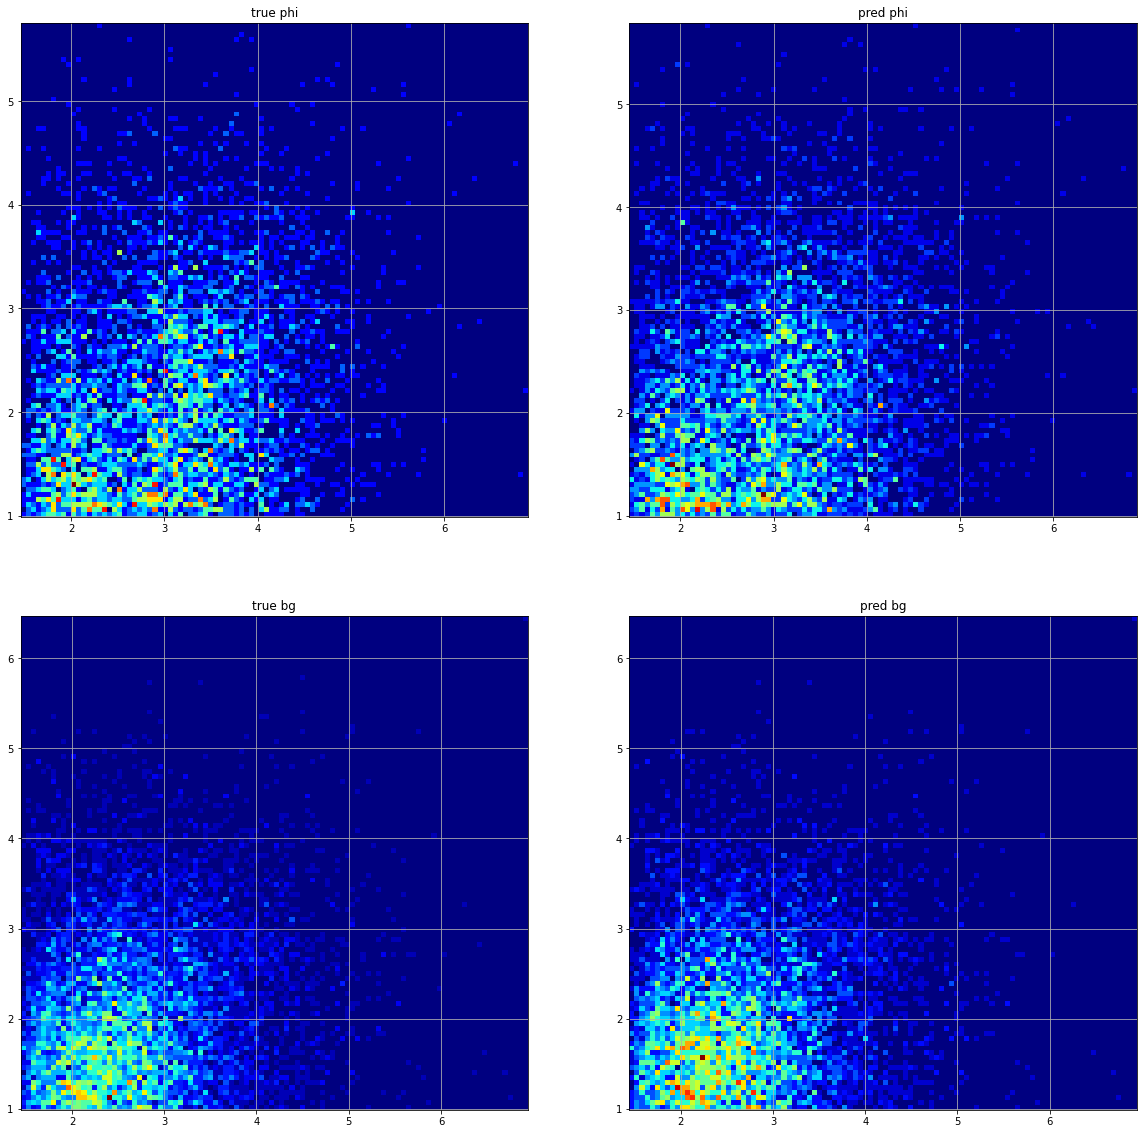

In [9]:
# Invariant Mass KpKm vs PrKm
# Root's 2D histogram is 100x better than matplotlib
# !: Not real because of StandardScaler
f, axs = plt.subplots(2, 2, figsize=(20,20))
for i, ax in enumerate(axs.flatten()):
    ax.set_title(["true phi", "pred phi", "true bg", "pred bg"][i])
    kpkm, prkm = [(phi_true[:, 16], phi_true[:, 17]), (phi_pred[:, 16], phi_pred[:, 17]), 
                    (bg_true[:, 16], bg_true[:, 17]), (bg_pred[:, 16], bg_pred[:, 17])][i]

    # xedges, yedges = np.linspace(0, 3, 50), np.linspace(0, 5, 50)
    # hist, xedges, yedges = np.histogram2d(prkm, kpkm, (xedges, yedges))
    # xidx = np.clip(np.digitize(prkm, xedges), 0, hist.shape[0]-1)
    # yidx = np.clip(np.digitize(kpkm, yedges), 0, hist.shape[1]-1)
    # c = hist[xidx, yidx]
    # ax.scatter(prkm, kpkm, c=c)#bins=50)
    ax.hist2d(prkm, kpkm, cmap='jet', bins=100)
    # _, b, _  = ax.hist(phi_true[:, i], bins=bins, histtype="step", label="phi true")
    
    ax.grid()
    # ax.set_yscale('log')